<h2> Import libraries <h2>

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


<h2> Read the data <h2>

In [2]:
df = pd.read_csv('baku_air_quality_data.csv')

<h2>  Convert timestamp to datetime<h2>

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

<h2> Setting the datetime as an index

In [4]:
df.set_index('timestamp' ,inplace = True)

<h2> Looking at the daily average  AQI <h2>

In [27]:
daily_aqi = df['aqi'].resample('D').mean()

<h1> Plotting the daily average AQI values for the entire period <h1>

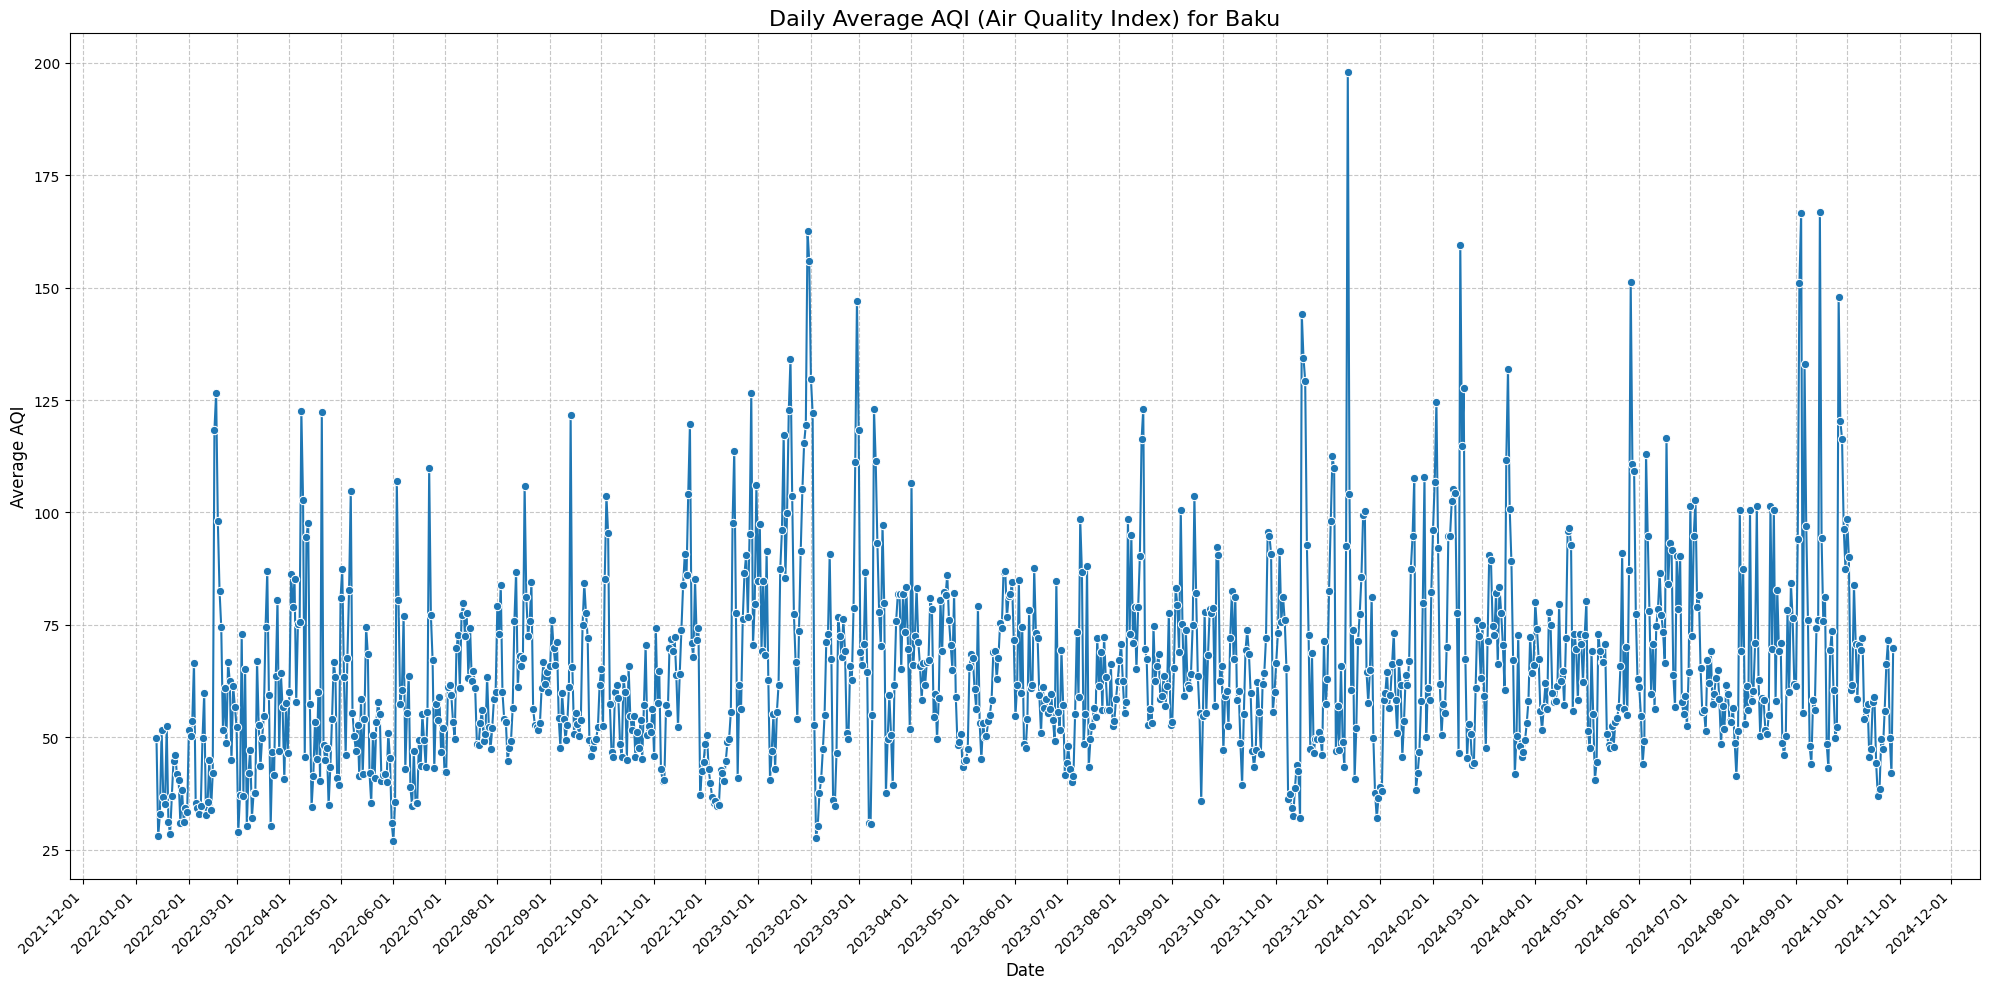

In [28]:
plt.figure(figsize = (20,10))
sns.lineplot(data = daily_aqi,marker='o')
plt.title('Daily Average AQI (Air Quality Index) for Baku', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average AQI', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')

# Show every 30th day on x-axis to avoid overcrowding
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

<h2> Perform ADF test to check for it's stationarity <h2>

In [29]:
aqi_daily = daily_aqi.dropna()
result = adfuller(aqi_daily)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -16.5482694741548
p-value: 1.9556344586617408e-29
Critical Values: {'1%': np.float64(-3.436783610904024), '5%': np.float64(-2.864380523665108), '10%': np.float64(-2.568282420632131)}


<h2> ACF  and PACF <h2>

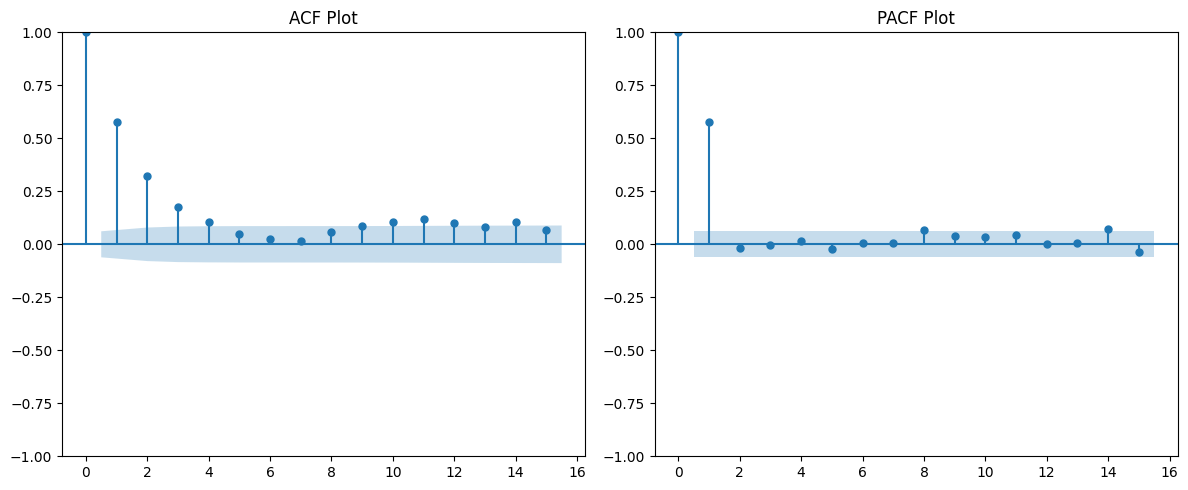

In [33]:


# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF on the left subplot
plot_acf(aqi_daily, lags=15, ax=axes[0])
axes[0].set_title("ACF Plot")

# Plot PACF on the right subplot
plot_pacf(aqi_daily, lags=15, ax=axes[1])
axes[1].set_title("PACF Plot")

# Show the combined plot
plt.tight_layout()
plt.show()


<h2> Train & Test split <h2>

In [35]:
split_percentage = 0.8
split_index =  int (len(aqi_daily)*split_percentage)

aqi_daily_train = aqi_daily[:split_index]
aqi_daily_test =  aqi_daily[split_index:]

print(len(aqi_daily_test))
print(len(aqi_daily_train))

204
816
